In [1]:
# Importing libraries and setting up the environment
import warnings

warnings.filterwarnings("ignore")  # setting ignore as a parameter
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from mpl_toolkits.basemap import Basemap
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from statsmodels.genmod.families import Binomial
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

image_format = "svg"

In [2]:
# Set Color Palette, PFT Labels, and a Function to plot bar plots

# Set Color Palette

palette = {
    "AS": "#cb7e0c",
    "BF": "#0F52BA",
    "MTF": "#9ACD32",
    "SG": "#EEBC1D",
    "TBEF": "#004953",
    "TCF": "#1b9d77",
    "TDF": "#7570b3",
    "XFW": "#A4D4B4",
    "Total": "grey",
}

  
short_pft_labels = {
    4: "BF",
    8: "MTF",
    9: "TCF",
    10: "TDF",
    13: "SG",
    15: "AS",
    19: "XFW",
    33: "TBEF",
    111: "Total",
}

pft_labels = {
    4: "Boreal Forests",
    8: "Mixed Temperate Forests",
    9: "Temperate Coniferous Forests",
    10: "Temperate Deciduous Forests",
    13: "Short Grasslands",
    15: "Arid Shrublands",
    19: "Xeromorphic Forests and Woodlands",
    33: "Temperate Broadleaved Evergreen Forests",
    99: "All PFTs",
    111: "Total",
}


# Function to read in data
def process_data(filepath):
    variable_data = pd.read_csv(
        filepath,
        names=[
            "POTVEG",
            "YEAR",
            "NGRID",
            "TOTCELLAREA",
            "TOTFORECOZONE",
            "MXPRED",
            "MNPRED",
            "MNBYAR",
            "SIMPMN",
            "STNDEV",
            "MNTOTYR",
        ],
    )

    return variable_data


# Shared paths

# .csv files share the same root directory
shared_root_path = (
    "C:/Users/jmkod/OneDrive/Desktop/Lehigh University/Research/Data/tem/processing/"
)
# .csv files for all models share the same path except for the model name
availn_data_shared_path = "/data/output_summary/AVAILN_BAKEOFF.SUMMARY"
gpp_data_shared_path = "/data/output_summary/GPP_BAKEOFF.SUMMARY"
h2oyield_data_shared_path = "/data/output_summary/H2OYIELD_BAKEOFF.SUMMARY"
vegc_data_shared_path = "/data/output_summary/VEGC_BAKEOFF.SUMMARY"
npp_data_shared_path = "/data/output_summary/NPP_BAKEOFF.SUMMARY"
nep_data_shared_path = "/data/output_summary/NEP_BAKEOFF.SUMMARY"
netnmin_data_shared_path = "/data/output_summary/NETNMIN_BAKEOFF.SUMMARY"
smois_data_shared_path = "/data/output_summary/SMOIS_BAKEOFF.SUMMARY"
soilorgc_data_shared_path = "/data/output_summary/SOILORGC_BAKEOFF.SUMMARY"
veginnpp_data_shared_path = "/data/output_summary/VEGINNPP_BAKEOFF.SUMMARY"
nce_data_shared_path = "/data/output_summary/NCE_BAKEOFF.SUMMARY"


# Function to process historical data
def process_dataset(filepath, dataset_name):
    # Import Current Data
    current_data = process_data(filepath)

    # Select Total For All PFTs (Current)
    total_current_yearly_pft = current_data.query(" POTVEG==99 and YEAR >= 1984")

    # Select last 30 Years for Current
    current_data = current_data.query("YEAR >= 1984 and POTVEG != 99")
    current_data = current_data[["POTVEG", "YEAR", "TOTFORECOZONE"]]

    # Rename Total Column
    current_data.rename(
        columns={"TOTFORECOZONE": f"CURRENT_TOTAL_{dataset_name}"},
        inplace=True,
    )
    current_data = current_data.append(
        {"POTVEG": 13, "YEAR": 2014, f"CURRENT_TOTAL_{dataset_name}": 0.000},
        ignore_index=True,
    )
    current_data = current_data.append(
        {"POTVEG": 15, "YEAR": 2014, f"CURRENT_TOTAL_{dataset_name}": 0.000},
        ignore_index=True,
    )
    return current_data


# Function to aggregate data
def aggregate_data(models, column, variable_name):
    agg_models = pd.concat(models)
    agg_models = (
        agg_models.groupby(["POTVEG", "YEAR"]).agg({column: "mean"}).reset_index()
    )
    agg_models.rename(
        columns={column: "END_CENTURY_TOTAL_" + variable_name}, inplace=True
    )
    agg_models["PFT"] = agg_models["POTVEG"]
    agg_models["PFT"] = agg_models["PFT"].map(short_pft_labels)
    return agg_models


# Function to create a  bar plot for % change in a variable
def create_bar_plot(data, title, power, n,units):
    sns.set(rc={"figure.figsize": (5, 5)})
    sns.set_theme(context="paper", style="ticks", font="sans-serif")
    sns.barplot(
        x="POTVEG",
        y=title + "_DIFFERENCE",
        palette=palette,
        # color="grey",
        edgecolor="black",
        width=0.5,
        linewidth=1,
        data=data,
    )

    plt.errorbar(
        x=data["POTVEG"],
        y=data[title + "_DIFFERENCE"],
        yerr=data["ERROR"],
        fmt="none",
        capsize=5,
        capthick=1,
        color="black",
    )

    plt.title(n+title, fontsize=12)
    plt.ylabel(f'Difference ($10^{power}${units})', fontsize=12)
   
#(10^3 TgC/30yrs) 
    plt.xlabel("", fontsize=12)
    plt.tick_params(labelsize=12)
    plt.rcParams["ytick.right"] = True
    plt.rcParams["ytick.minor.size"] = 5
    plt.rcParams["ytick.major.size"] = 10
    plt.rcParams["ytick.minor.visible"] = False
    plt.rcParams["figure.autolayout"] = True

    plt.tight_layout()
    plt.savefig(
        "../figures/" + title.lower() + "_change." + image_format,
        format=image_format,
        dpi=1200,
        bbox_inches="tight",
    )

In [3]:
# Import Data


# Australia
vegc_model_1 = process_data(
    shared_root_path + "australia" + vegc_data_shared_path
)  # VEGC
npp_model_1 = process_data(shared_root_path + "australia" + npp_data_shared_path)  # NPP
nep_model_1 = process_data(shared_root_path + "australia" + nep_data_shared_path)  #
availn_model_1 = process_data(
    shared_root_path + "australia" + availn_data_shared_path
)  # AVAILN
gpp_model_1 = process_data(shared_root_path + "australia" + gpp_data_shared_path)  # GPP
h2o_model_1 = process_data(
    shared_root_path + "australia" + h2oyield_data_shared_path
)  # H2OYIELD
netnmin_model_1 = process_data(
    shared_root_path + "australia" + netnmin_data_shared_path
)  # NETNMIN
smois_model_1 = process_data(
    shared_root_path + "australia" + smois_data_shared_path
)  # SMOIS
soilorgc_model_1 = process_data(
    shared_root_path + "australia" + soilorgc_data_shared_path
)  # SOILORGC
veginnpp_model_1 = process_data(
    shared_root_path + "australia" + veginnpp_data_shared_path
)  # VEGINNPP

nce_model_1 = process_data(shared_root_path + "australia" + nce_data_shared_path)  # NCE


# Canada
vegc_model_2 = process_data(shared_root_path + "canada" + vegc_data_shared_path)  # VEGC
npp_model_2 = process_data(shared_root_path + "canada" + npp_data_shared_path)  # NPP
nep_model_2 = process_data(shared_root_path + "canada" + nep_data_shared_path)  # NEP
availn_model_2 = process_data(
    shared_root_path + "canada" + availn_data_shared_path
)  # AVAILN
gpp_model_2 = process_data(shared_root_path + "canada" + gpp_data_shared_path)  # GPP
h2o_model_2 = process_data(
    shared_root_path + "canada" + h2oyield_data_shared_path
)  # H2OYIELD
netnmin_model_2 = process_data(
    shared_root_path + "canada" + netnmin_data_shared_path
)  # NETNMIN
smois_model_2 = process_data(
    shared_root_path + "canada" + smois_data_shared_path
)  # SMOIS
soilorgc_model_2 = process_data(
    shared_root_path + "canada" + soilorgc_data_shared_path
)  # SOILORGC
veginnpp_model_2 = process_data(
    shared_root_path + "canada" + veginnpp_data_shared_path
)  # VEGINNPP

nce_model_2 = process_data(shared_root_path + "canada" + nce_data_shared_path)  # NCE

# China
vegc_model_3 = process_data(shared_root_path + "china" + vegc_data_shared_path)  # VEGC
npp_model_3 = process_data(shared_root_path + "china" + npp_data_shared_path)  # NPP
nep_model_3 = process_data(shared_root_path + "china" + nep_data_shared_path)  # NEP
availn_model_3 = process_data(
    shared_root_path + "china" + availn_data_shared_path
)  # AVAILN
gpp_model_3 = process_data(shared_root_path + "china" + gpp_data_shared_path)  # GPP
h2o_model_3 = process_data(
    shared_root_path + "china" + h2oyield_data_shared_path
)  # H2OYIELD
netnmin_model_3 = process_data(
    shared_root_path + "china" + netnmin_data_shared_path
)  # NETNMIN
smois_model_3 = process_data(
    shared_root_path + "china" + smois_data_shared_path
)  # SMOIS
soilorgc_model_3 = process_data(
    shared_root_path + "china" + soilorgc_data_shared_path
)  # SOILORGC
veginnpp_model_3 = process_data(
    shared_root_path + "china" + veginnpp_data_shared_path
)  # VEGINNPP

nce_model_3 = process_data(shared_root_path + "china" + nce_data_shared_path)  # NCE

# France
vegc_model_4 = process_data(shared_root_path + "france" + vegc_data_shared_path)  # VEGC
npp_model_4 = process_data(shared_root_path + "france" + npp_data_shared_path)  # NPP
nep_model_4 = process_data(shared_root_path + "france" + nep_data_shared_path)  # NEP
availn_model_4 = process_data(
    shared_root_path + "france" + availn_data_shared_path
)  # AVAILN
gpp_model_4 = process_data(shared_root_path + "france" + gpp_data_shared_path)  # GPP
h2o_model_4 = process_data(
    shared_root_path + "france" + h2oyield_data_shared_path
)  # H2OYIELD
netnmin_model_4 = process_data(
    shared_root_path + "france" + netnmin_data_shared_path
)  # NETNMIN
smois_model_4 = process_data(
    shared_root_path + "france" + smois_data_shared_path
)  # SMOIS
soilorgc_model_4 = process_data(
    shared_root_path + "france" + soilorgc_data_shared_path
)  # SOILORGC
veginnpp_model_4 = process_data(
    shared_root_path + "france" + veginnpp_data_shared_path
)  # VEGINNPP

nce_model_4 = process_data(shared_root_path + "france" + nce_data_shared_path)  # NCE

# Japan
vegc_model_5 = process_data(shared_root_path + "japan" + vegc_data_shared_path)  # VEGC
npp_model_5 = process_data(shared_root_path + "japan" + npp_data_shared_path)  # NPP
nep_model_5 = process_data(shared_root_path + "japan" + nep_data_shared_path)  # NEP
availn_model_5 = process_data(
    shared_root_path + "japan" + availn_data_shared_path
)  # AVAILN
gpp_model_5 = process_data(shared_root_path + "japan" + gpp_data_shared_path)  # GPP
h2o_model_5 = process_data(
    shared_root_path + "japan" + h2oyield_data_shared_path
)  # H2OYIELD
netnmin_model_5 = process_data(
    shared_root_path + "japan" + netnmin_data_shared_path
)  # NETNMIN
smois_model_5 = process_data(
    shared_root_path + "japan" + smois_data_shared_path
)  # SMOIS
soilorgc_model_5 = process_data(
    shared_root_path + "japan" + soilorgc_data_shared_path
)  # SOILORGC
veginnpp_model_5 = process_data(
    shared_root_path + "japan" + veginnpp_data_shared_path
)  # VEGINNPP

nce_model_5 = process_data(shared_root_path + "japan" + nce_data_shared_path)  # NCE

# Norway
vegc_model_6 = process_data(shared_root_path + "norway" + vegc_data_shared_path)  # VEGC
npp_model_6 = process_data(shared_root_path + "norway" + npp_data_shared_path)  # NPP
nep_model_6 = process_data(shared_root_path + "norway" + nep_data_shared_path)  # NEP
availn_model_6 = process_data(
    shared_root_path + "norway" + availn_data_shared_path
)  # AVAILN
gpp_model_6 = process_data(shared_root_path + "norway" + gpp_data_shared_path)  # GPP
h2o_model_6 = process_data(
    shared_root_path + "norway" + h2oyield_data_shared_path
)  # H2OYIELD
netnmin_model_6 = process_data(
    shared_root_path + "norway" + netnmin_data_shared_path
)  # NETNMIN
smois_model_6 = process_data(
    shared_root_path + "norway" + smois_data_shared_path
)  # SMOIS
soilorgc_model_6 = process_data(
    shared_root_path + "norway" + soilorgc_data_shared_path
)  # SOILORGC
veginnpp_model_6 = process_data(
    shared_root_path + "norway" + veginnpp_data_shared_path
)  # VEGINNPP

nce_model_6 = process_data(shared_root_path + "norway" + nce_data_shared_path)  # NCE

# United Kingdom
vegc_model_7 = process_data(
    shared_root_path + "united_kingdom" + vegc_data_shared_path
)  # VEGC
npp_model_7 = process_data(
    shared_root_path + "united_kingdom" + npp_data_shared_path
)  # NPP
nep_model_7 = process_data(
    shared_root_path + "united_kingdom" + nep_data_shared_path
)  # NEP
availn_model_7 = process_data(
    shared_root_path + "united_kingdom" + availn_data_shared_path
)  # AVAILN
gpp_model_7 = process_data(
    shared_root_path + "united_kingdom" + gpp_data_shared_path
)  # GPP
h2o_model_7 = process_data(
    shared_root_path + "united_kingdom" + h2oyield_data_shared_path
)  # H2OYIELD
netnmin_model_7 = process_data(
    shared_root_path + "united_kingdom" + netnmin_data_shared_path
)  # NETNMIN
smois_model_7 = process_data(
    shared_root_path + "united_kingdom" + smois_data_shared_path
)  # SMOIS
soilorgc_model_7 = process_data(
    shared_root_path + "united_kingdom" + soilorgc_data_shared_path
)  # SOILORGC
veginnpp_model_7 = process_data(
    shared_root_path + "united_kingdom" + veginnpp_data_shared_path
)  # VEGINNPP

nce_model_7 = process_data(shared_root_path + "united_kingdom" + nce_data_shared_path)  # NCE

# United States CCSM4
vegc_model_8 = process_data(
    shared_root_path + "united_states_1" + vegc_data_shared_path
)  # VEGC
npp_model_8 = process_data(
    shared_root_path + "united_states_1" + npp_data_shared_path
)  # NPP
nep_model_8 = process_data(
    shared_root_path + "united_states_1" + nep_data_shared_path
)  # NEP
availn_model_8 = process_data(
    shared_root_path + "united_states_1" + availn_data_shared_path
)  # AVAILN
gpp_model_8 = process_data(
    shared_root_path + "united_states_1" + gpp_data_shared_path
)  # GPP
h2o_model_8 = process_data(
    shared_root_path + "united_states_1" + h2oyield_data_shared_path
)  # H2OYIELD
netnmin_model_8 = process_data(
    shared_root_path + "united_states_1" + netnmin_data_shared_path
)  # NETNMIN
smois_model_8 = process_data(
    shared_root_path + "united_states_1" + smois_data_shared_path
)  # SMOIS
soilorgc_model_8 = process_data(
    shared_root_path + "united_states_1" + soilorgc_data_shared_path
)  # SOILORGC
veginnpp_model_8 = process_data(
    shared_root_path + "united_states_1" + veginnpp_data_shared_path
)  # VEGINNPP

nce_model_8 = process_data(shared_root_path + "united_states_1" + nce_data_shared_path)  # NCE

# United States GFDL
vegc_model_9 = process_data(
    shared_root_path + "united_states_2" + vegc_data_shared_path
)  # VEGC
npp_model_9 = process_data(
    shared_root_path + "united_states_2" + npp_data_shared_path
)  # NPP
nep_model_9 = process_data(
    shared_root_path + "united_states_2" + nep_data_shared_path
)  # NEP
availn_model_9 = process_data(
    shared_root_path + "united_states_2" + availn_data_shared_path
)  # AVAILN
gpp_model_9 = process_data(
    shared_root_path + "united_states_2" + gpp_data_shared_path
)  # GPP
h2o_model_9 = process_data(
    shared_root_path + "united_states_2" + h2oyield_data_shared_path
)  # H2OYIELD
netnmin_model_9 = process_data(
    shared_root_path + "united_states_2" + netnmin_data_shared_path
)  # NETNMIN
smois_model_9 = process_data(
    shared_root_path + "united_states_2" + smois_data_shared_path
)  # SMOIS
soilorgc_model_9 = process_data(
    shared_root_path + "united_states_2" + soilorgc_data_shared_path
)  # SOILORGC
veginnpp_model_9 = process_data(
    shared_root_path + "united_states_2" + veginnpp_data_shared_path
)  # VEGINNPP

nce_model_9 = process_data(shared_root_path + "united_states_2" + nce_data_shared_path)  # NCE


# Historical data
current_vegc = process_dataset(
    "../data/historical/ORIGINAL_LULC_VEGC.SUMMARY", "VEGC"
)  # VEGC
current_npp = process_dataset(
    "../data/historical/ORIGINAL_LULC_NPP.SUMMARY", "NPP"
)  # NPP
current_nep = process_dataset(
    "../data/historical/ORIGINAL_LULC_NEP.SUMMARY", "NEP"
)  # NEP
current_availn = process_dataset(
    "../data/historical/ORIGINAL_LULC_AVAILN.SUMMARY", "AVAILN"
)  # AVAILN
current_gpp = process_dataset(
    "../data/historical/ORIGINAL_LULC_GPP.SUMMARY", "GPP"
)  # GPP
current_h2oyield = process_dataset(
    "../data/historical/ORIGINAL_LULC_H2OYIELD.SUMMARY", "H2OYIELD"
)  # H2OYIELD
current_netnmin = process_dataset(
    "../data/historical/ORIGINAL_LULC_NETNMIN.SUMMARY", "NETNMIN"
)  # NETNMIN
current_smois = process_dataset(
    "../data/historical/ORIGINAL_LULC_SMOIS.SUMMARY", "SMOIS"
)  # SMOIS
current_soilorgc = process_dataset(
    "../data/historical/ORIGINAL_LULC_SOILORGC.SUMMARY", "SOILORGC"
)  # SOILORGC
current_veginnpp = process_dataset(
    "../data/historical/ORIGINAL_LULC_VEGINNPP.SUMMARY", "VEGINNPP"
)  # VEGINNPP

current_nce = process_dataset("../data/historical/ORIGINAL_LULC_NCE.SUMMARY", "NCE")  # NCE

In [4]:
# Variables to list of future models dataframes
vegc_models = [
    vegc_model_1,
    vegc_model_2,
    vegc_model_3,
    vegc_model_4,
    vegc_model_5,
    vegc_model_6,
    vegc_model_7,
    vegc_model_8,
    vegc_model_9,
]
npp_models = [
    npp_model_1,
    npp_model_2,
    npp_model_3,
    npp_model_4,
    npp_model_5,
    npp_model_6,
    npp_model_7,
    npp_model_8,
    npp_model_9,
]
nep_models = [
    nep_model_1,
    nep_model_2,
    nep_model_3,
    nep_model_4,
    nep_model_5,
    nep_model_6,
    nep_model_7,
    nep_model_8,
    nep_model_9,
]
availn_models = [
    availn_model_1,
    availn_model_2,
    availn_model_3,
    availn_model_4,
    availn_model_5,
    availn_model_6,
    availn_model_7,
    availn_model_8,
    availn_model_9,
]
gpp_models = [
    gpp_model_1,
    gpp_model_2,
    gpp_model_3,
    gpp_model_4,
    gpp_model_5,
    gpp_model_6,
    gpp_model_7,
    gpp_model_8,
    gpp_model_9,
]
h2oyield_models = [
    h2o_model_1,
    h2o_model_2,
    h2o_model_3,
    h2o_model_4,
    h2o_model_5,
    h2o_model_6,
    h2o_model_7,
    h2o_model_8,
    h2o_model_9,
]
netnmin_models = [
    netnmin_model_1,
    netnmin_model_2,
    netnmin_model_3,
    netnmin_model_4,
    netnmin_model_5,
    netnmin_model_6,
    netnmin_model_7,
    netnmin_model_8,
    netnmin_model_9,
]
smois_models = [
    smois_model_1,
    smois_model_2,
    smois_model_3,
    smois_model_4,
    smois_model_5,
    smois_model_6,
    smois_model_7,
    smois_model_8,
    smois_model_9,
]
soilorgc_models = [
    soilorgc_model_1,
    soilorgc_model_2,
    soilorgc_model_3,
    soilorgc_model_4,
    soilorgc_model_5,
    soilorgc_model_6,
    soilorgc_model_7,
    soilorgc_model_8,
    soilorgc_model_9,
]
veginnpp_models = [
    veginnpp_model_1,
    veginnpp_model_2,
    veginnpp_model_3,
    veginnpp_model_4,
    veginnpp_model_5,
    veginnpp_model_6,
    veginnpp_model_7,
    veginnpp_model_8,
    veginnpp_model_9,
]

nce_models = [
    nce_model_1,
    nce_model_2,
    nce_model_3,
    nce_model_4,
    nce_model_5,
    nce_model_6,
    nce_model_7,
    nce_model_8,
    nce_model_9,
]

In [5]:
# Aggregate data
vegc_agg_models = aggregate_data(vegc_models, "TOTFORECOZONE", "VEGC")
npp_agg_models = aggregate_data(npp_models, "TOTFORECOZONE", "NPP")
nep_agg_models = aggregate_data(nep_models, "TOTFORECOZONE", "NEP")
availn_agg_models = aggregate_data(availn_models, "TOTFORECOZONE", "AVAILN")
gpp_agg_models = aggregate_data(gpp_models, "TOTFORECOZONE", "GPP")
h2oyield_agg_models = aggregate_data(h2oyield_models, "TOTFORECOZONE", "H2OYIELD")
netnmin_agg_models = aggregate_data(netnmin_models, "TOTFORECOZONE", "NETNMIN")
smois_agg_models = aggregate_data(smois_models, "TOTFORECOZONE", "SMOIS")
soilorgc_agg_models = aggregate_data(soilorgc_models, "TOTFORECOZONE", "SOILORGC")
veginnpp_agg_models = aggregate_data(veginnpp_models, "TOTFORECOZONE", "VEGINNPP")
nce_agg_models = aggregate_data(nce_models, "TOTFORECOZONE", "NCE")

# Filter future_vegc_mean to only include rows where 'YEAR' is >= 2070 and 'POTVEG' is not 99
end_century_vegc = vegc_agg_models.query("YEAR>= 2069 and POTVEG != 99")  # VEGC
end_century_npp = npp_agg_models.query("YEAR>= 2069 and POTVEG != 99")  # NPP
end_century_nep = nep_agg_models.query("YEAR>= 2069 and POTVEG != 99")  # NEP
end_century_availn = availn_agg_models.query("YEAR>= 2069 and POTVEG != 99")  # AVAILN
end_century_gpp = gpp_agg_models.query("YEAR>= 2069 and POTVEG != 99")  # GPP
end_century_h2oyield = h2oyield_agg_models.query("YEAR>= 2069 and POTVEG != 99")  # H2O
end_century_netnmin = netnmin_agg_models.query(
    "YEAR>= 2069 and POTVEG != 99"
)  # NETNMIN
end_century_smois = smois_agg_models.query("YEAR>= 2069 and POTVEG != 99")  # SMOIS
end_century_soilorgc = soilorgc_agg_models.query(
    "YEAR>= 2069 and POTVEG != 99"
)  # SOILORGC
end_century_veginnpp = veginnpp_agg_models.query(
    "YEAR>= 2069 and POTVEG != 99"
)  # VEGINNPP

end_century_nce = nce_agg_models.query("YEAR>= 2069 and POTVEG != 99")  # NCE

In [6]:
# For exporting data to tables used in the paper

"""
# Fuction to calulate, se, sum, and merge dataframes for each variable
def calculate_se_sum_merge(current_df, end_century_df, variable):
    # Calculate se of variable for each pft for current
    current_se = (
        (current_df.groupby(["POTVEG"])[f"CURRENT_TOTAL_{variable}"].sem() * 1.96)
        .reset_index()
        .rename(columns={f"CURRENT_TOTAL_{variable}": "CURRENT_ERROR"})
    )
    current_se.fillna(0, inplace=True)

    # Calculate sum of variable for each pft for current
    current_sum = (
        current_df.groupby(["POTVEG"])[f"CURRENT_TOTAL_{variable}"].sum().round(2)
    ).reset_index()

    # Calculate se of variable for each pft for  future
    end_century_se = (
        (end_century_df.groupby(["POTVEG"])[f"END_CENTURY_TOTAL_{variable}"].sem() * 1.96)
        .reset_index()
        .rename(columns={f"END_CENTURY_TOTAL_{variable}": "END_CENTURY_ERROR"})
    )

    # Calculate sum of variable for each pft for end of century
    end_century_sum = (
        end_century_df.groupby(["POTVEG"])[f"END_CENTURY_TOTAL_{variable}"].sum().round(2)
    ).reset_index()

    # Merge CURRENT_sum and END_CENTURY_sum dataframes
    merged_df = current_sum.merge(
        end_century_sum, on="POTVEG", suffixes=("_CURRENT", "_FUTURE")
    )

    # Add ERROR columns for current and future conditions
    merged_df["CURRENT_ERROR"] = current_se["CURRENT_ERROR"].round(2)
    merged_df["FUTURE_ERROR"] = end_century_se["END_CENTURY_ERROR"].round(2)

    return merged_df

# Apply calculate_se_sum_merge function to each variable
vegc_merged_df=calculate_se_sum_merge(current_vegc, end_century_vegc, "VEGC")
npp_merged_df=calculate_se_sum_merge(current_npp, end_century_npp, "NPP")
nep_merged_df=calculate_se_sum_merge(current_nep, end_century_nep, "NEP")
availn_merged_df=calculate_se_sum_merge(current_availn, end_century_availn, "AVAILN")
gpp_merged_df=calculate_se_sum_merge(current_gpp, end_century_gpp, "GPP")
h2oyield_merged_df=calculate_se_sum_merge(current_h2oyield, end_century_h2oyield, "H2OYIELD")
netnmin_merged_df=calculate_se_sum_merge(current_netnmin, end_century_netnmin, "NETNMIN")
smois_merged_df=calculate_se_sum_merge(current_smois, end_century_smois, "SMOIS")
soilorgc_merged_df=calculate_se_sum_merge(current_soilorgc, end_century_soilorgc, "SOILORGC")
veginnpp_meregd_df=calculate_se_sum_merge(current_veginnpp, end_century_veginnpp, "VEGINNPP")
nce_merged_df=calculate_se_sum_merge(current_nce, end_century_nce, "NCE")


# Function to Combine the columns of current  sum and current ERROR into a single string separated by ± symbol

def combine_vegc_error(df, variable):
    df[f"{variable}_CURRENT"] = (
        df[f"CURRENT_TOTAL_{variable}"].astype(str)
        + " ± "
        + df["CURRENT_ERROR"].astype(str)
    )
    df[f"{variable}_FUTURE"] = (
        df[f"END_CENTURY_TOTAL_{variable}"].astype(str)
        + " ± "
        + df["FUTURE_ERROR"].astype(str)
    )
    df=df[['POTVEG', f'{variable}_CURRENT', f'{variable}_FUTURE']]
    df["POTVEG"] = df["POTVEG"].map(pft_labels)
    return df

vegc_se_sum_merged = combine_vegc_error(vegc_merged_df, "VEGC")
npp_se_sum_merged = combine_vegc_error(npp_merged_df, "NPP")
nep_se_sum_merged = combine_vegc_error(nep_merged_df, "NEP")
availn_se_sum_merged = combine_vegc_error(availn_merged_df, "AVAILN")
gpp_se_sum_merged = combine_vegc_error(gpp_merged_df, "GPP")
h2oyield_se_sum_merged = combine_vegc_error(h2oyield_merged_df, "H2OYIELD")
netnmin_se_sum_merged = combine_vegc_error(netnmin_merged_df, "NETNMIN")
smois_se_sum_merged = combine_vegc_error(smois_merged_df, "SMOIS")
soilorgc_se_sum_merged = combine_vegc_error(soilorgc_merged_df, "SOILORGC")
veginnpp_se_sum_merged = combine_vegc_error(veginnpp_meregd_df, "VEGINNPP")
nce_se_sum_merged = combine_vegc_error(nce_merged_df, "NCE")

# Save Data Frames to CSV
vegc_se_sum_merged.to_csv("../data/data_summary_table.csv", index=False)
npp_se_sum_merged.to_csv("../data/data_summary_table.csv", index=False, mode='a', header=True)
nep_se_sum_merged.to_csv("../data/data_summary_table.csv", index=False, mode='a', header=True)
availn_se_sum_merged.to_csv("../data/data_summary_table.csv", index=False, mode='a', header=True)
gpp_se_sum_merged.to_csv("../data/data_summary_table.csv", index=False, mode='a', header=True)
h2oyield_se_sum_merged.to_csv("../data/data_summary_table.csv", index=False, mode='a', header=True)
netnmin_se_sum_merged.to_csv("../data/data_summary_table.csv", index=False, mode='a', header=True)
smois_se_sum_merged.to_csv("../data/data_summary_table.csv", index=False, mode='a', header=True)
soilorgc_se_sum_merged.to_csv("../data/data_summary_table.csv", index=False, mode='a', header=True)
veginnpp_se_sum_merged.to_csv("../data/data_summary_table.csv", index=False, mode='a', header=True)
nce_se_sum_merged.to_csv("../data/data_summary_table.csv", index=False, mode='a', header=True)

"""

print("1")

1


In [7]:
# Function to calculate se of variables for each pft for current and future,
# calculate variable Difference ,
# calculate se of  Difference,
# calculate absolute value of errors and add standard errors to variable_difference dataframe,
# reorder columns, and add pft names to variable_difference dataframe


def calculate_variable_difference(variable, current_df, end_century_df, divide_by):
    # Calculate se of variable for each pft for current
    current_variable_se = (
        (current_df.groupby(["POTVEG"])[f"CURRENT_TOTAL_{variable}"].sem() * 1.96)
        .reset_index()
        .rename(columns={f"CURRENT_TOTAL_{variable}": "CURRENT_ERROR"})
    )
    current_variable_se.fillna(0, inplace=True)

    
    # Calculate se of variable for each pft for future
    end_century_variable_se = (
        (
            end_century_df.groupby(["POTVEG"])[f"END_CENTURY_TOTAL_{variable}"].sem()
            * 1.96
        )
        .reset_index()
        .rename(columns={f"END_CENTURY_TOTAL_{variable}": "END_CENTURY_ERROR"})
    )
    end_century_variable_se.fillna(0, inplace=True)

    current_df=current_df.groupby(["POTVEG"])[f"CURRENT_TOTAL_{variable}"].sum().reset_index()
    end_century_df=end_century_df.groupby(["POTVEG"])[f"END_CENTURY_TOTAL_{variable}"].sum().reset_index()
   
    # add a row at the bottom of the dataframe with the sum of the values in each column, the row will be labeled "Total"
    current_df.loc[8] = current_df.sum(numeric_only=True, axis=0)
    
    end_century_df.loc[8] = end_century_df.sum(numeric_only=True, axis=0)
    
    # Calculate variable Difference
    variable_difference = current_df.merge(
        end_century_df, on="POTVEG"
    )

    variable_difference[f"{variable}_DIFFERENCE"] = (
        variable_difference[f"END_CENTURY_TOTAL_{variable}"]
        - variable_difference[f"CURRENT_TOTAL_{variable}"]
    )
    variable_difference["ERROR"] = (
    (end_century_variable_se["END_CENTURY_ERROR"] ** 2 + current_variable_se["CURRENT_ERROR"] ** 2) ** 0.5
    ).round(2)
    
    variable_difference[f"{variable}_DIFFERENCE"] = variable_difference[f"{variable}_DIFFERENCE"]/divide_by
    variable_difference["ERROR"] = variable_difference["ERROR"]/divide_by
    variable_difference=variable_difference[['POTVEG', f'{variable}_DIFFERENCE', 'ERROR']]
    variable_difference["POTVEG"] = variable_difference["POTVEG"].map(short_pft_labels)
    
    # Set the ERROR column of the Total row to the sum of the ERROR column of all rows
    variable_difference.loc[8, "ERROR"] = variable_difference["ERROR"].sum()
    return variable_difference


# Apply calculate_variable_difference function to each variable
vegc_difference = calculate_variable_difference(
    "VEGC", current_vegc, end_century_vegc, 100000
)
npp_difference = calculate_variable_difference(
    "NPP", current_npp, end_century_npp ,1000
)
nep_difference = calculate_variable_difference(
    "NEP", current_nep, end_century_nep,10
)
availn_difference = calculate_variable_difference(
    "AVAILN", current_availn, end_century_availn,100000
)
gpp_difference = calculate_variable_difference(
    "GPP", current_gpp, end_century_gpp,10
)
h2oyield_difference = calculate_variable_difference(
    "H2OYIELD", current_h2oyield, end_century_h2oyield,10
)
netnmin_difference = calculate_variable_difference(
    "NETNMIN", current_netnmin, end_century_netnmin,10000
)
smois_difference = calculate_variable_difference(
    "SMOIS", current_smois, end_century_smois,10
)
soilorgc_difference = calculate_variable_difference(
    "SOILORGC", current_soilorgc, end_century_soilorgc,100000
)
veginnpp_difference = calculate_variable_difference(
    "VEGINNPP", current_veginnpp, end_century_veginnpp,10
    
 )
nce_difference = calculate_variable_difference("NCE",current_nce, end_century_nce, 10000)


# Merge the two dataframes on the "POTVEG" column
necb_difference = pd.merge(nep_difference, nce_difference, on='POTVEG')

# Calculate the NECB_DIFFERENCE column by subtracting NEP_DIFFERENCE from NCE_DIFFERENCE
necb_difference['NECB_DIFFERENCE'] = necb_difference['NEP_DIFFERENCE'] - necb_difference['NCE_DIFFERENCE']

# Calculate the error of the difference using error propagation
necb_difference['ERROR'] = np.sqrt(necb_difference['ERROR_x']**2 + necb_difference['ERROR_y']**2)

# Select only the columns we want in the resulting dataframe
necb_difference= necb_difference[['POTVEG', 'NECB_DIFFERENCE', 'ERROR']]
necb_difference["NECB_DIFFERENCE"] = necb_difference["NECB_DIFFERENCE"]/1000
necb_difference["ERROR"] = necb_difference["ERROR"]/1000



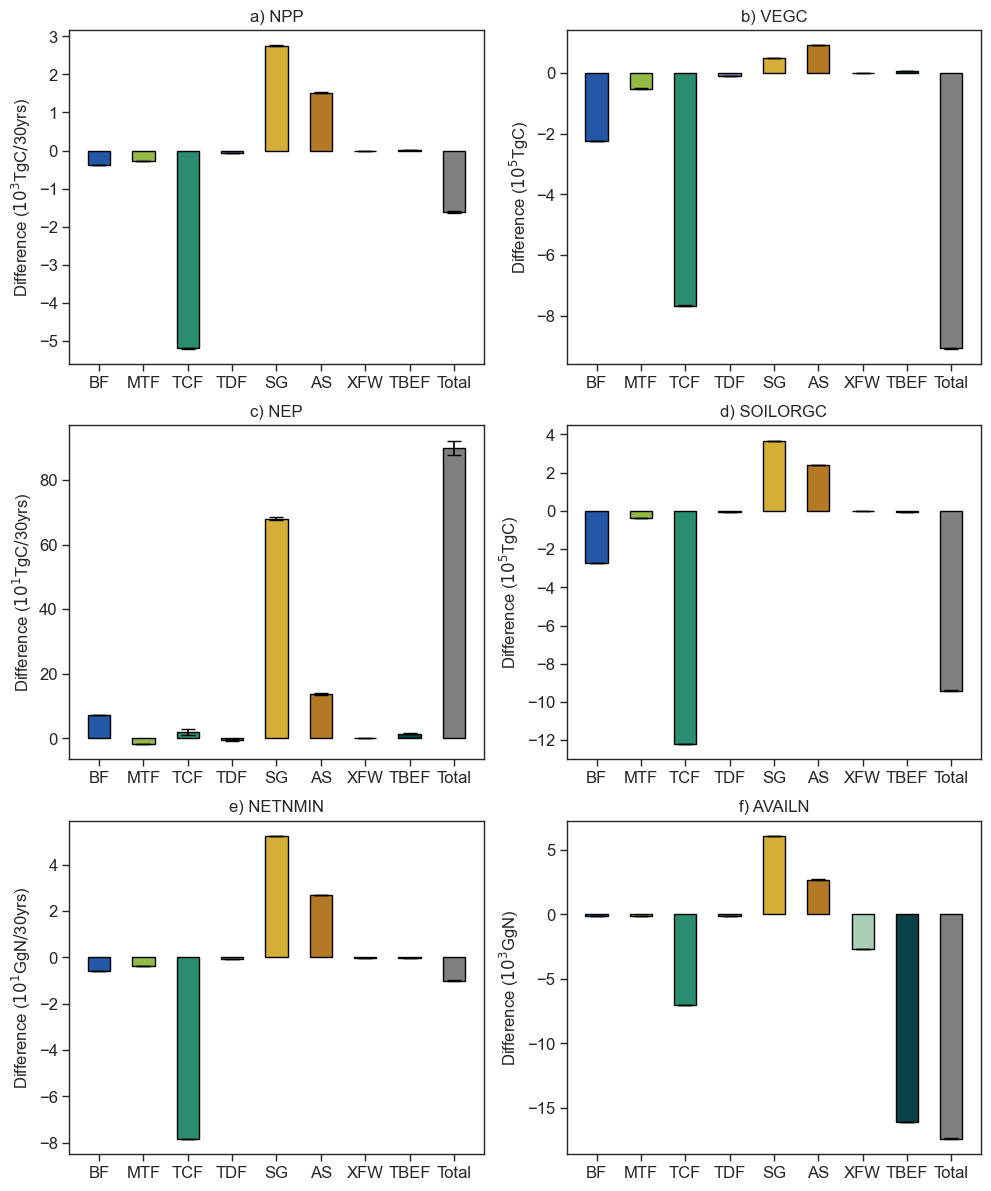

In [16]:
#Plot all Data
#Create a list with all the data frames
data = [npp_difference, vegc_difference, nep_difference, soilorgc_difference, netnmin_difference, availn_difference]

tittle = ["NPP", "VEGC", "NEP",  "SOILORGC", "NETNMIN", "AVAILN"]
power= [3,5,1,5,1,3]
n = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) "]
units = ["TgC$/$30yrs", "TgC","TgC$/$30yrs", "TgC", "GgN$/$30yrs", "GgN"]



fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,12))
sns.set_theme(context="paper", style="ticks", font="sans-serif")

for idx, ax in enumerate(axs.flatten()):
    
    sns.barplot(ax=ax,
        x="POTVEG",
        y=tittle[idx] + "_DIFFERENCE",
        palette=palette,
        # color="grey",
        edgecolor="black",
        width=0.5,
        linewidth=1,
        data=data[idx],
    )

    ax.errorbar(
        x=data[idx]["POTVEG"],
        y=data[idx][tittle[idx] + "_DIFFERENCE"],
        yerr=data[idx]["ERROR"],
        fmt="none",
        capsize=5,
        capthick=1,
        color="black",
    )

    ax.set_title(n[idx]+tittle[idx], fontsize=12)
    ax.set_ylabel(f'Difference ($10^{power[idx]}${units[idx]})', fontsize=12)   
    # (10^3 TgC/30yrs) 
    ax.set_xlabel("", fontsize=12)
    ax.tick_params(labelsize=12)
   

plt.savefig("../figures/C_and_N_total.svg", dpi=1200, format="svg",bbox_inches="tight")

plt.show()

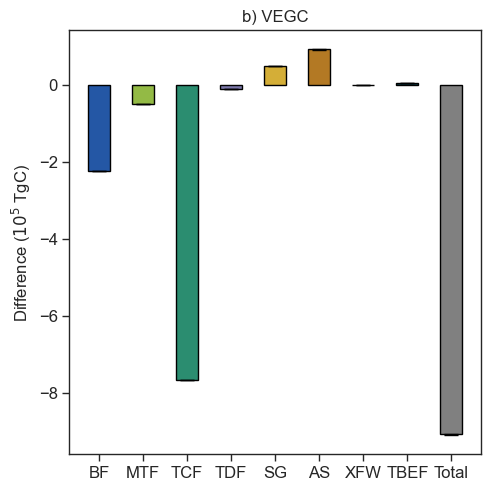

In [9]:
# Plot VEGC
create_bar_plot(vegc_difference, "VEGC",5,"b) ", " TgC")

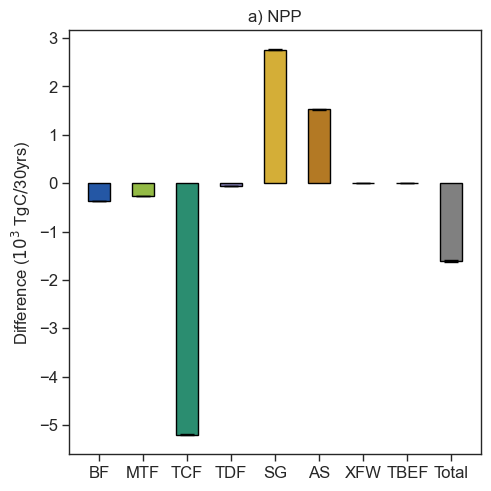

In [10]:
# Plot NPP
create_bar_plot(npp_difference, "NPP",3, "a) ", " TgC$/$30yrs")

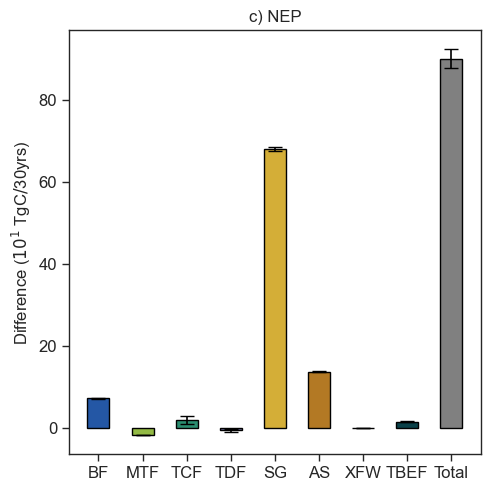

In [11]:
# Plot NEP
create_bar_plot(nep_difference, "NEP", 1, "c) ", " TgC$/$30yrs")

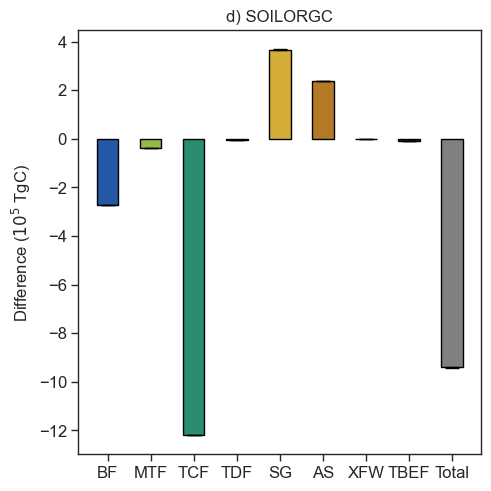

In [12]:
# Plot SOILORGC
create_bar_plot(soilorgc_difference, "SOILORGC",5, "d) ", " TgC")

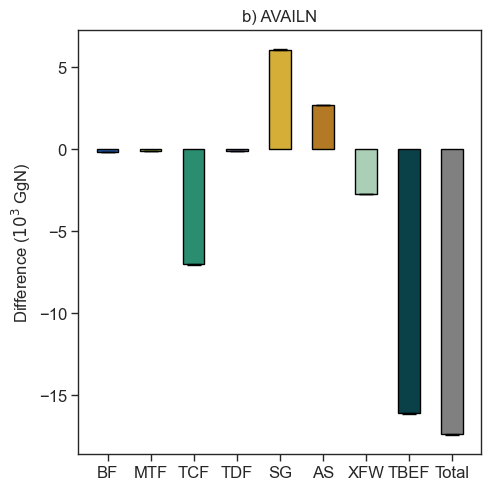

In [13]:
create_bar_plot(availn_difference, "AVAILN", 3, "b) ", " GgN")

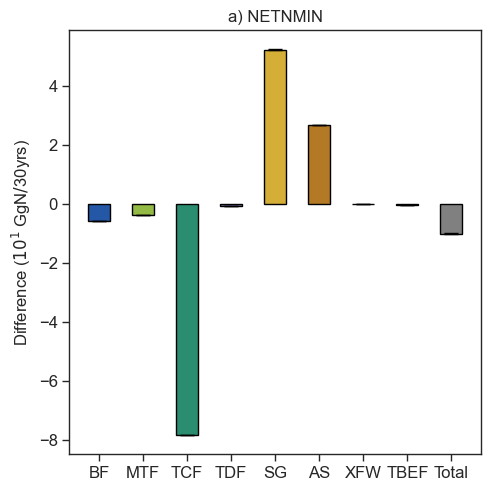

In [14]:
create_bar_plot(netnmin_difference, "NETNMIN", 1, "a) ", " GgN$/$30yrs")